In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:29 - loss: 2.0397 - STD: 0.0700 - MAE: 0.2151

 15/773 [..............................] - ETA: 2s - loss: 1.4118 - STD: 0.1876 - MAE: 0.1487   

 29/773 [>.............................] - ETA: 2s - loss: 1.3669 - STD: 0.1916 - MAE: 0.1462

 42/773 [>.............................] - ETA: 2s - loss: 1.3577 - STD: 0.1896 - MAE: 0.1471

 55/773 [=>............................] - ETA: 2s - loss: 1.3516 - STD: 0.1900 - MAE: 0.1469

 67/773 [=>............................] - ETA: 2s - loss: 1.3451 - STD: 0.1901 - MAE: 0.1467

 79/773 [==>...........................] - ETA: 2s - loss: 1.3414 - STD: 0.1902 - MAE: 0.1465

 91/773 [==>...........................] - ETA: 2s - loss: 1.3367 - STD: 0.1904 - MAE: 0.1463

105/773 [===>..........................] - ETA: 2s - loss: 1.3310 - STD: 0.1905 - MAE: 0.1461

121/773 [===>..........................] - ETA: 2s - loss: 1.3223 - STD: 0.1911 - MAE: 0.1455

134/773 [====>.........................] - ETA: 2s - loss: 1.3139 - STD: 0.1916 - MAE: 0.1450

147/773 [====>.........................] - ETA: 2s - loss: 1.3037 - STD: 0.1922 - MAE: 0.1445

162/773 [=====>........................] - ETA: 2s - loss: 1.2936 - STD: 0.1930 - MAE: 0.1439

174/773 [=====>........................] - ETA: 2s - loss: 1.2845 - STD: 0.1934 - MAE: 0.1434

187/773 [======>.......................] - ETA: 2s - loss: 1.2745 - STD: 0.1940 - MAE: 0.1429

203/773 [======>.......................] - ETA: 2s - loss: 1.2629 - STD: 0.1946 - MAE: 0.1424

219/773 [=======>......................] - ETA: 2s - loss: 1.2510 - STD: 0.1954 - MAE: 0.1417

235/773 [========>.....................] - ETA: 2s - loss: 1.2392 - STD: 0.1960 - MAE: 0.1411

249/773 [========>.....................] - ETA: 1s - loss: 1.2291 - STD: 0.1967 - MAE: 0.1405

262/773 [=========>....................] - ETA: 1s - loss: 1.2188 - STD: 0.1975 - MAE: 0.1398

279/773 [=========>....................] - ETA: 1s - loss: 1.2067 - STD: 0.1984 - MAE: 0.1390

296/773 [==========>...................] - ETA: 1s - loss: 1.1946 - STD: 0.1994 - MAE: 0.1381

313/773 [===========>..................] - ETA: 1s - loss: 1.1822 - STD: 0.2005 - MAE: 0.1372

330/773 [===========>..................] - ETA: 1s - loss: 1.1700 - STD: 0.2015 - MAE: 0.1363

347/773 [============>.................] - ETA: 1s - loss: 1.1580 - STD: 0.2025 - MAE: 0.1355

364/773 [=============>................] - ETA: 1s - loss: 1.1468 - STD: 0.2035 - MAE: 0.1346

381/773 [=============>................] - ETA: 1s - loss: 1.1367 - STD: 0.2044 - MAE: 0.1339

398/773 [==============>...............] - ETA: 1s - loss: 1.1273 - STD: 0.2052 - MAE: 0.1332

414/773 [===============>..............] - ETA: 1s - loss: 1.1185 - STD: 0.2060 - MAE: 0.1325

427/773 [===============>..............] - ETA: 1s - loss: 1.1125 - STD: 0.2066 - MAE: 0.1320

440/773 [================>.............] - ETA: 1s - loss: 1.1059 - STD: 0.2072 - MAE: 0.1315

455/773 [================>.............] - ETA: 1s - loss: 1.0989 - STD: 0.2078 - MAE: 0.1310

471/773 [=================>............] - ETA: 1s - loss: 1.0916 - STD: 0.2085 - MAE: 0.1304

487/773 [=================>............] - ETA: 1s - loss: 1.0844 - STD: 0.2091 - MAE: 0.1298

501/773 [==================>...........] - ETA: 0s - loss: 1.0793 - STD: 0.2097 - MAE: 0.1294

517/773 [===================>..........] - ETA: 0s - loss: 1.0732 - STD: 0.2103 - MAE: 0.1289

530/773 [===================>..........] - ETA: 0s - loss: 1.0687 - STD: 0.2108 - MAE: 0.1285

543/773 [====================>.........] - ETA: 0s - loss: 1.0640 - STD: 0.2112 - MAE: 0.1282

553/773 [====================>.........] - ETA: 1s - loss: 1.0605 - STD: 0.2115 - MAE: 0.1279

566/773 [====================>.........] - ETA: 0s - loss: 1.0562 - STD: 0.2119 - MAE: 0.1275

578/773 [=====================>........] - ETA: 0s - loss: 1.0523 - STD: 0.2123 - MAE: 0.1272

590/773 [=====================>........] - ETA: 0s - loss: 1.0486 - STD: 0.2127 - MAE: 0.1269

603/773 [======================>.......] - ETA: 0s - loss: 1.0446 - STD: 0.2130 - MAE: 0.1266

616/773 [======================>.......] - ETA: 0s - loss: 1.0410 - STD: 0.2134 - MAE: 0.1263

629/773 [=======================>......] - ETA: 0s - loss: 1.0373 - STD: 0.2138 - MAE: 0.1260

641/773 [=======================>......] - ETA: 0s - loss: 1.0340 - STD: 0.2141 - MAE: 0.1257

655/773 [========================>.....] - ETA: 0s - loss: 1.0301 - STD: 0.2145 - MAE: 0.1254

672/773 [=========================>....] - ETA: 0s - loss: 1.0259 - STD: 0.2149 - MAE: 0.1250

690/773 [=========================>....] - ETA: 0s - loss: 1.0210 - STD: 0.2154 - MAE: 0.1246

706/773 [==========================>...] - ETA: 0s - loss: 1.0173 - STD: 0.2157 - MAE: 0.1243

722/773 [===========================>..] - ETA: 0s - loss: 1.0135 - STD: 0.2161 - MAE: 0.1240

740/773 [===========================>..] - ETA: 0s - loss: 1.0094 - STD: 0.2165 - MAE: 0.1237

755/773 [============================>.] - ETA: 0s - loss: 1.0059 - STD: 0.2169 - MAE: 0.1234

767/773 [============================>.] - ETA: 0s - loss: 1.0032 - STD: 0.2171 - MAE: 0.1231

773/773 [==============================] - 5s 5ms/step - loss: 1.0018 - STD: 0.2173 - MAE: 0.1230 - val_loss: 0.8643 - val_STD: 0.2417 - val_MAE: 0.1035


Epoch 2/10000


  1/773 [..............................] - ETA: 14s - loss: 0.8241 - STD: 0.2412 - MAE: 0.1051

 14/773 [..............................] - ETA: 3s - loss: 0.8352 - STD: 0.2341 - MAE: 0.1087 

 27/773 [>.............................] - ETA: 3s - loss: 0.8371 - STD: 0.2338 - MAE: 0.1090

 40/773 [>.............................] - ETA: 2s - loss: 0.8351 - STD: 0.2343 - MAE: 0.1087

 53/773 [=>............................] - ETA: 2s - loss: 0.8358 - STD: 0.2338 - MAE: 0.1089

 65/773 [=>............................] - ETA: 2s - loss: 0.8335 - STD: 0.2342 - MAE: 0.1086

 78/773 [==>...........................] - ETA: 2s - loss: 0.8315 - STD: 0.2343 - MAE: 0.1085

 92/773 [==>...........................] - ETA: 2s - loss: 0.8320 - STD: 0.2343 - MAE: 0.1086

108/773 [===>..........................] - ETA: 2s - loss: 0.8321 - STD: 0.2342 - MAE: 0.1087

126/773 [===>..........................] - ETA: 2s - loss: 0.8308 - STD: 0.2342 - MAE: 0.1086

142/773 [====>.........................] - ETA: 2s - loss: 0.8292 - STD: 0.2345 - MAE: 0.1084

159/773 [=====>........................] - ETA: 2s - loss: 0.8274 - STD: 0.2347 - MAE: 0.1082

175/773 [=====>........................] - ETA: 2s - loss: 0.8280 - STD: 0.2349 - MAE: 0.1082

192/773 [======>.......................] - ETA: 2s - loss: 0.8259 - STD: 0.2348 - MAE: 0.1081

209/773 [=======>......................] - ETA: 1s - loss: 0.8235 - STD: 0.2350 - MAE: 0.1079

226/773 [=======>......................] - ETA: 1s - loss: 0.8219 - STD: 0.2352 - MAE: 0.1078

242/773 [========>.....................] - ETA: 1s - loss: 0.8208 - STD: 0.2352 - MAE: 0.1077

259/773 [=========>....................] - ETA: 1s - loss: 0.8200 - STD: 0.2353 - MAE: 0.1076

277/773 [=========>....................] - ETA: 1s - loss: 0.8199 - STD: 0.2353 - MAE: 0.1076

294/773 [==========>...................] - ETA: 1s - loss: 0.8184 - STD: 0.2353 - MAE: 0.1076

310/773 [===========>..................] - ETA: 1s - loss: 0.8170 - STD: 0.2354 - MAE: 0.1074

326/773 [===========>..................] - ETA: 1s - loss: 0.8169 - STD: 0.2355 - MAE: 0.1074

342/773 [============>.................] - ETA: 1s - loss: 0.8157 - STD: 0.2356 - MAE: 0.1073

357/773 [============>.................] - ETA: 1s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1072

374/773 [=============>................] - ETA: 1s - loss: 0.8140 - STD: 0.2358 - MAE: 0.1072

390/773 [==============>...............] - ETA: 1s - loss: 0.8141 - STD: 0.2358 - MAE: 0.1072

408/773 [==============>...............] - ETA: 1s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1071

425/773 [===============>..............] - ETA: 1s - loss: 0.8127 - STD: 0.2360 - MAE: 0.1070

437/773 [===============>..............] - ETA: 1s - loss: 0.8117 - STD: 0.2360 - MAE: 0.1070

450/773 [================>.............] - ETA: 1s - loss: 0.8109 - STD: 0.2361 - MAE: 0.1069

462/773 [================>.............] - ETA: 1s - loss: 0.8107 - STD: 0.2362 - MAE: 0.1069

475/773 [=================>............] - ETA: 1s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1068

492/773 [==================>...........] - ETA: 0s - loss: 0.8084 - STD: 0.2364 - MAE: 0.1066

509/773 [==================>...........] - ETA: 0s - loss: 0.8078 - STD: 0.2364 - MAE: 0.1066

524/773 [===================>..........] - ETA: 0s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1065

539/773 [===================>..........] - ETA: 0s - loss: 0.8064 - STD: 0.2366 - MAE: 0.1064

552/773 [====================>.........] - ETA: 0s - loss: 0.8066 - STD: 0.2366 - MAE: 0.1064

564/773 [====================>.........] - ETA: 0s - loss: 0.8060 - STD: 0.2367 - MAE: 0.1064

576/773 [=====================>........] - ETA: 0s - loss: 0.8050 - STD: 0.2368 - MAE: 0.1063

588/773 [=====================>........] - ETA: 0s - loss: 0.8044 - STD: 0.2368 - MAE: 0.1062

603/773 [======================>.......] - ETA: 0s - loss: 0.8032 - STD: 0.2369 - MAE: 0.1061

619/773 [=======================>......] - ETA: 0s - loss: 0.8020 - STD: 0.2370 - MAE: 0.1060

635/773 [=======================>......] - ETA: 0s - loss: 0.8011 - STD: 0.2371 - MAE: 0.1059

650/773 [========================>.....] - ETA: 0s - loss: 0.8008 - STD: 0.2372 - MAE: 0.1059

661/773 [========================>.....] - ETA: 0s - loss: 0.8003 - STD: 0.2372 - MAE: 0.1058

674/773 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2373 - MAE: 0.1058

690/773 [=========================>....] - ETA: 0s - loss: 0.7986 - STD: 0.2374 - MAE: 0.1057

703/773 [==========================>...] - ETA: 0s - loss: 0.7978 - STD: 0.2374 - MAE: 0.1056

719/773 [==========================>...] - ETA: 0s - loss: 0.7969 - STD: 0.2375 - MAE: 0.1055

736/773 [===========================>..] - ETA: 0s - loss: 0.7959 - STD: 0.2376 - MAE: 0.1054

752/773 [============================>.] - ETA: 0s - loss: 0.7953 - STD: 0.2377 - MAE: 0.1054

768/773 [============================>.] - ETA: 0s - loss: 0.7946 - STD: 0.2377 - MAE: 0.1053

773/773 [==============================] - 3s 4ms/step - loss: 0.7943 - STD: 0.2378 - MAE: 0.1053 - val_loss: 0.7528 - val_STD: 0.2420 - val_MAE: 0.0997


Epoch 3/10000


  1/773 [..............................] - ETA: 17s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1010

 13/773 [..............................] - ETA: 3s - loss: 0.7616 - STD: 0.2392 - MAE: 0.1034 

 25/773 [..............................] - ETA: 3s - loss: 0.7598 - STD: 0.2408 - MAE: 0.1023

 38/773 [>.............................] - ETA: 3s - loss: 0.7622 - STD: 0.2409 - MAE: 0.1024

 50/773 [>.............................] - ETA: 3s - loss: 0.7599 - STD: 0.2410 - MAE: 0.1022

 62/773 [=>............................] - ETA: 3s - loss: 0.7601 - STD: 0.2411 - MAE: 0.1021

 74/773 [=>............................] - ETA: 2s - loss: 0.7590 - STD: 0.2415 - MAE: 0.1019

 89/773 [==>...........................] - ETA: 2s - loss: 0.7581 - STD: 0.2413 - MAE: 0.1020

102/773 [==>...........................] - ETA: 2s - loss: 0.7572 - STD: 0.2415 - MAE: 0.1018

118/773 [===>..........................] - ETA: 2s - loss: 0.7576 - STD: 0.2415 - MAE: 0.1018

134/773 [====>.........................] - ETA: 2s - loss: 0.7586 - STD: 0.2416 - MAE: 0.1018

150/773 [====>.........................] - ETA: 2s - loss: 0.7581 - STD: 0.2416 - MAE: 0.1018

168/773 [=====>........................] - ETA: 2s - loss: 0.7576 - STD: 0.2415 - MAE: 0.1018

184/773 [======>.......................] - ETA: 2s - loss: 0.7566 - STD: 0.2416 - MAE: 0.1017

198/773 [======>.......................] - ETA: 2s - loss: 0.7559 - STD: 0.2417 - MAE: 0.1016

212/773 [=======>......................] - ETA: 2s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1015

226/773 [=======>......................] - ETA: 2s - loss: 0.7544 - STD: 0.2418 - MAE: 0.1015

238/773 [========>.....................] - ETA: 1s - loss: 0.7543 - STD: 0.2418 - MAE: 0.1015

250/773 [========>.....................] - ETA: 1s - loss: 0.7538 - STD: 0.2419 - MAE: 0.1014

265/773 [=========>....................] - ETA: 1s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1013

281/773 [=========>....................] - ETA: 1s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1012

298/773 [==========>...................] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1011

314/773 [===========>..................] - ETA: 1s - loss: 0.7503 - STD: 0.2423 - MAE: 0.1010

326/773 [===========>..................] - ETA: 1s - loss: 0.7500 - STD: 0.2424 - MAE: 0.1009

340/773 [============>.................] - ETA: 1s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1009

356/773 [============>.................] - ETA: 1s - loss: 0.7494 - STD: 0.2424 - MAE: 0.1009

372/773 [=============>................] - ETA: 1s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1008

388/773 [==============>...............] - ETA: 1s - loss: 0.7490 - STD: 0.2425 - MAE: 0.1008

404/773 [==============>...............] - ETA: 1s - loss: 0.7486 - STD: 0.2426 - MAE: 0.1008

421/773 [===============>..............] - ETA: 1s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1008

438/773 [===============>..............] - ETA: 1s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1008

455/773 [================>.............] - ETA: 1s - loss: 0.7484 - STD: 0.2426 - MAE: 0.1008

473/773 [=================>............] - ETA: 1s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1008

490/773 [==================>...........] - ETA: 0s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1008

507/773 [==================>...........] - ETA: 0s - loss: 0.7488 - STD: 0.2426 - MAE: 0.1008

524/773 [===================>..........] - ETA: 0s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1008

541/773 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2426 - MAE: 0.1008

558/773 [====================>.........] - ETA: 0s - loss: 0.7475 - STD: 0.2426 - MAE: 0.1008

575/773 [=====================>........] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

592/773 [=====================>........] - ETA: 0s - loss: 0.7464 - STD: 0.2427 - MAE: 0.1007

610/773 [======================>.......] - ETA: 0s - loss: 0.7458 - STD: 0.2427 - MAE: 0.1006

628/773 [=======================>......] - ETA: 0s - loss: 0.7452 - STD: 0.2428 - MAE: 0.1006

646/773 [========================>.....] - ETA: 0s - loss: 0.7447 - STD: 0.2428 - MAE: 0.1005

663/773 [========================>.....] - ETA: 0s - loss: 0.7448 - STD: 0.2429 - MAE: 0.1005

679/773 [=========================>....] - ETA: 0s - loss: 0.7447 - STD: 0.2429 - MAE: 0.1005

695/773 [=========================>....] - ETA: 0s - loss: 0.7445 - STD: 0.2429 - MAE: 0.1005

711/773 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1005

726/773 [===========================>..] - ETA: 0s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1005

738/773 [===========================>..] - ETA: 0s - loss: 0.7451 - STD: 0.2429 - MAE: 0.1005

750/773 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2429 - MAE: 0.1005

764/773 [============================>.] - ETA: 0s - loss: 0.7448 - STD: 0.2430 - MAE: 0.1005

773/773 [==============================] - 3s 4ms/step - loss: 0.7446 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7377 - val_STD: 0.2404 - val_MAE: 0.0997


Epoch 4/10000


  1/773 [..............................] - ETA: 16s - loss: 0.7157 - STD: 0.2437 - MAE: 0.0976

 17/773 [..............................] - ETA: 2s - loss: 0.7206 - STD: 0.2441 - MAE: 0.0988 

 34/773 [>.............................] - ETA: 2s - loss: 0.7203 - STD: 0.2446 - MAE: 0.0986

 51/773 [>.............................] - ETA: 2s - loss: 0.7188 - STD: 0.2449 - MAE: 0.0982

 68/773 [=>............................] - ETA: 2s - loss: 0.7214 - STD: 0.2444 - MAE: 0.0987

 85/773 [==>...........................] - ETA: 2s - loss: 0.7219 - STD: 0.2444 - MAE: 0.0987

103/773 [==>...........................] - ETA: 2s - loss: 0.7202 - STD: 0.2448 - MAE: 0.0984

121/773 [===>..........................] - ETA: 1s - loss: 0.7188 - STD: 0.2450 - MAE: 0.0983

139/773 [====>.........................] - ETA: 1s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0981

156/773 [=====>........................] - ETA: 1s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0981

173/773 [=====>........................] - ETA: 1s - loss: 0.7173 - STD: 0.2452 - MAE: 0.0980

190/773 [======>.......................] - ETA: 1s - loss: 0.7175 - STD: 0.2453 - MAE: 0.0980

207/773 [=======>......................] - ETA: 1s - loss: 0.7183 - STD: 0.2452 - MAE: 0.0981

224/773 [=======>......................] - ETA: 1s - loss: 0.7187 - STD: 0.2452 - MAE: 0.0982

241/773 [========>.....................] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0981

258/773 [=========>....................] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0981

275/773 [=========>....................] - ETA: 1s - loss: 0.7205 - STD: 0.2453 - MAE: 0.0982

293/773 [==========>...................] - ETA: 1s - loss: 0.7198 - STD: 0.2453 - MAE: 0.0982

309/773 [==========>...................] - ETA: 1s - loss: 0.7193 - STD: 0.2453 - MAE: 0.0981

326/773 [===========>..................] - ETA: 1s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0980

343/773 [============>.................] - ETA: 1s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0980

360/773 [============>.................] - ETA: 1s - loss: 0.7179 - STD: 0.2455 - MAE: 0.0979

377/773 [=============>................] - ETA: 1s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0979

394/773 [==============>...............] - ETA: 1s - loss: 0.7176 - STD: 0.2456 - MAE: 0.0979

411/773 [==============>...............] - ETA: 1s - loss: 0.7171 - STD: 0.2456 - MAE: 0.0978

427/773 [===============>..............] - ETA: 1s - loss: 0.7170 - STD: 0.2457 - MAE: 0.0978

443/773 [================>.............] - ETA: 0s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0978

461/773 [================>.............] - ETA: 0s - loss: 0.7172 - STD: 0.2456 - MAE: 0.0978

479/773 [=================>............] - ETA: 0s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0978

496/773 [==================>...........] - ETA: 0s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0978

512/773 [==================>...........] - ETA: 0s - loss: 0.7162 - STD: 0.2457 - MAE: 0.0977

529/773 [===================>..........] - ETA: 0s - loss: 0.7157 - STD: 0.2458 - MAE: 0.0977

545/773 [====================>.........] - ETA: 0s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0977

561/773 [====================>.........] - ETA: 0s - loss: 0.7151 - STD: 0.2458 - MAE: 0.0976

578/773 [=====================>........] - ETA: 0s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0976

592/773 [=====================>........] - ETA: 0s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0976

606/773 [======================>.......] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0975

622/773 [=======================>......] - ETA: 0s - loss: 0.7137 - STD: 0.2459 - MAE: 0.0975

639/773 [=======================>......] - ETA: 0s - loss: 0.7134 - STD: 0.2460 - MAE: 0.0975

657/773 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0974

675/773 [=========================>....] - ETA: 0s - loss: 0.7128 - STD: 0.2461 - MAE: 0.0974

693/773 [=========================>....] - ETA: 0s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0974

711/773 [==========================>...] - ETA: 0s - loss: 0.7128 - STD: 0.2461 - MAE: 0.0974

729/773 [===========================>..] - ETA: 0s - loss: 0.7125 - STD: 0.2461 - MAE: 0.0973

747/773 [===========================>..] - ETA: 0s - loss: 0.7123 - STD: 0.2462 - MAE: 0.0973

765/773 [============================>.] - ETA: 0s - loss: 0.7121 - STD: 0.2462 - MAE: 0.0973

773/773 [==============================] - 3s 3ms/step - loss: 0.7121 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.7496 - val_STD: 0.2533 - val_MAE: 0.0937


Epoch 5/10000


  1/773 [..............................] - ETA: 17s - loss: 0.7082 - STD: 0.2542 - MAE: 0.0931

 15/773 [..............................] - ETA: 2s - loss: 0.7090 - STD: 0.2457 - MAE: 0.0974 

 31/773 [>.............................] - ETA: 2s - loss: 0.7045 - STD: 0.2467 - MAE: 0.0967

 47/773 [>.............................] - ETA: 2s - loss: 0.7035 - STD: 0.2469 - MAE: 0.0966

 61/773 [=>............................] - ETA: 2s - loss: 0.7013 - STD: 0.2472 - MAE: 0.0962

 74/773 [=>............................] - ETA: 2s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0961

 86/773 [==>...........................] - ETA: 2s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0960

102/773 [==>...........................] - ETA: 2s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0959

119/773 [===>..........................] - ETA: 2s - loss: 0.6966 - STD: 0.2476 - MAE: 0.0958

136/773 [====>.........................] - ETA: 2s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0957

152/773 [====>.........................] - ETA: 2s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0958

169/773 [=====>........................] - ETA: 2s - loss: 0.6986 - STD: 0.2476 - MAE: 0.0959

186/773 [======>.......................] - ETA: 1s - loss: 0.6991 - STD: 0.2475 - MAE: 0.0960

203/773 [======>.......................] - ETA: 1s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0959

219/773 [=======>......................] - ETA: 1s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0959

236/773 [========>.....................] - ETA: 1s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0958

253/773 [========>.....................] - ETA: 1s - loss: 0.6975 - STD: 0.2477 - MAE: 0.0958

270/773 [=========>....................] - ETA: 1s - loss: 0.6975 - STD: 0.2476 - MAE: 0.0959

288/773 [==========>...................] - ETA: 1s - loss: 0.6973 - STD: 0.2478 - MAE: 0.0958

306/773 [==========>...................] - ETA: 1s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0957

323/773 [===========>..................] - ETA: 1s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0956

341/773 [============>.................] - ETA: 1s - loss: 0.6962 - STD: 0.2479 - MAE: 0.0957

358/773 [============>.................] - ETA: 1s - loss: 0.6966 - STD: 0.2479 - MAE: 0.0957

375/773 [=============>................] - ETA: 1s - loss: 0.6960 - STD: 0.2479 - MAE: 0.0957

392/773 [==============>...............] - ETA: 1s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0955

409/773 [==============>...............] - ETA: 1s - loss: 0.6954 - STD: 0.2480 - MAE: 0.0956

426/773 [===============>..............] - ETA: 1s - loss: 0.6952 - STD: 0.2481 - MAE: 0.0955

443/773 [================>.............] - ETA: 1s - loss: 0.6942 - STD: 0.2481 - MAE: 0.0954

461/773 [================>.............] - ETA: 0s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0955

478/773 [=================>............] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0955

496/773 [==================>...........] - ETA: 0s - loss: 0.6943 - STD: 0.2481 - MAE: 0.0954

513/773 [==================>...........] - ETA: 0s - loss: 0.6942 - STD: 0.2482 - MAE: 0.0954

528/773 [===================>..........] - ETA: 0s - loss: 0.6940 - STD: 0.2481 - MAE: 0.0954

544/773 [====================>.........] - ETA: 0s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0954

560/773 [====================>.........] - ETA: 0s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0953

577/773 [=====================>........] - ETA: 0s - loss: 0.6928 - STD: 0.2482 - MAE: 0.0953

594/773 [======================>.......] - ETA: 0s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0953

609/773 [======================>.......] - ETA: 0s - loss: 0.6919 - STD: 0.2483 - MAE: 0.0952

625/773 [=======================>......] - ETA: 0s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0952

641/773 [=======================>......] - ETA: 0s - loss: 0.6913 - STD: 0.2484 - MAE: 0.0952

656/773 [========================>.....] - ETA: 0s - loss: 0.6910 - STD: 0.2484 - MAE: 0.0951

673/773 [=========================>....] - ETA: 0s - loss: 0.6910 - STD: 0.2484 - MAE: 0.0951

691/773 [=========================>....] - ETA: 0s - loss: 0.6907 - STD: 0.2485 - MAE: 0.0951

708/773 [==========================>...] - ETA: 0s - loss: 0.6904 - STD: 0.2485 - MAE: 0.0951

725/773 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0950

742/773 [===========================>..] - ETA: 0s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0950

759/773 [============================>.] - ETA: 0s - loss: 0.6898 - STD: 0.2486 - MAE: 0.0950

773/773 [==============================] - 3s 3ms/step - loss: 0.6898 - STD: 0.2486 - MAE: 0.0950 - val_loss: 0.7422 - val_STD: 0.2450 - val_MAE: 0.0979


Epoch 6/10000


  1/773 [..............................] - ETA: 12s - loss: 0.6802 - STD: 0.2484 - MAE: 0.0951

 14/773 [..............................] - ETA: 2s - loss: 0.6576 - STD: 0.2509 - MAE: 0.0918 

 25/773 [..............................] - ETA: 3s - loss: 0.6638 - STD: 0.2508 - MAE: 0.0922

 37/773 [>.............................] - ETA: 3s - loss: 0.6725 - STD: 0.2503 - MAE: 0.0931

 48/773 [>.............................] - ETA: 3s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0933

 65/773 [=>............................] - ETA: 2s - loss: 0.6806 - STD: 0.2496 - MAE: 0.0940

 82/773 [==>...........................] - ETA: 2s - loss: 0.6822 - STD: 0.2496 - MAE: 0.0941

 98/773 [==>...........................] - ETA: 2s - loss: 0.6832 - STD: 0.2495 - MAE: 0.0942

114/773 [===>..........................] - ETA: 2s - loss: 0.6823 - STD: 0.2493 - MAE: 0.0943

130/773 [====>.........................] - ETA: 2s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0941

147/773 [====>.........................] - ETA: 2s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0941

163/773 [=====>........................] - ETA: 2s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0940

179/773 [=====>........................] - ETA: 2s - loss: 0.6802 - STD: 0.2495 - MAE: 0.0941

195/773 [======>.......................] - ETA: 1s - loss: 0.6800 - STD: 0.2494 - MAE: 0.0941

211/773 [=======>......................] - ETA: 1s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0941

224/773 [=======>......................] - ETA: 1s - loss: 0.6799 - STD: 0.2495 - MAE: 0.0940

236/773 [========>.....................] - ETA: 1s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0941

247/773 [========>.....................] - ETA: 1s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0941

259/773 [=========>....................] - ETA: 1s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0940

271/773 [=========>....................] - ETA: 1s - loss: 0.6792 - STD: 0.2496 - MAE: 0.0939

283/773 [=========>....................] - ETA: 1s - loss: 0.6789 - STD: 0.2496 - MAE: 0.0939

297/773 [==========>...................] - ETA: 1s - loss: 0.6782 - STD: 0.2496 - MAE: 0.0939

310/773 [===========>..................] - ETA: 1s - loss: 0.6774 - STD: 0.2498 - MAE: 0.0938

325/773 [===========>..................] - ETA: 1s - loss: 0.6769 - STD: 0.2499 - MAE: 0.0937

338/773 [============>.................] - ETA: 1s - loss: 0.6767 - STD: 0.2498 - MAE: 0.0937

352/773 [============>.................] - ETA: 1s - loss: 0.6773 - STD: 0.2498 - MAE: 0.0937

370/773 [=============>................] - ETA: 1s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0937

386/773 [=============>................] - ETA: 1s - loss: 0.6764 - STD: 0.2500 - MAE: 0.0936

403/773 [==============>...............] - ETA: 1s - loss: 0.6762 - STD: 0.2500 - MAE: 0.0936

421/773 [===============>..............] - ETA: 1s - loss: 0.6753 - STD: 0.2500 - MAE: 0.0935

438/773 [===============>..............] - ETA: 1s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0934

455/773 [================>.............] - ETA: 1s - loss: 0.6739 - STD: 0.2501 - MAE: 0.0934

471/773 [=================>............] - ETA: 1s - loss: 0.6736 - STD: 0.2502 - MAE: 0.0933

485/773 [=================>............] - ETA: 1s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0933

502/773 [==================>...........] - ETA: 0s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0933

519/773 [===================>..........] - ETA: 0s - loss: 0.6736 - STD: 0.2503 - MAE: 0.0933

535/773 [===================>..........] - ETA: 0s - loss: 0.6732 - STD: 0.2503 - MAE: 0.0932

553/773 [====================>.........] - ETA: 0s - loss: 0.6728 - STD: 0.2504 - MAE: 0.0932

570/773 [=====================>........] - ETA: 0s - loss: 0.6726 - STD: 0.2504 - MAE: 0.0931

586/773 [=====================>........] - ETA: 0s - loss: 0.6723 - STD: 0.2504 - MAE: 0.0931

603/773 [======================>.......] - ETA: 0s - loss: 0.6719 - STD: 0.2504 - MAE: 0.0931

620/773 [=======================>......] - ETA: 0s - loss: 0.6713 - STD: 0.2504 - MAE: 0.0930

635/773 [=======================>......] - ETA: 0s - loss: 0.6707 - STD: 0.2505 - MAE: 0.0930

651/773 [========================>.....] - ETA: 0s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0930

667/773 [========================>.....] - ETA: 0s - loss: 0.6708 - STD: 0.2505 - MAE: 0.0930

682/773 [=========================>....] - ETA: 0s - loss: 0.6709 - STD: 0.2505 - MAE: 0.0930

699/773 [==========================>...] - ETA: 0s - loss: 0.6712 - STD: 0.2505 - MAE: 0.0930

716/773 [==========================>...] - ETA: 0s - loss: 0.6707 - STD: 0.2505 - MAE: 0.0930

733/773 [===========================>..] - ETA: 0s - loss: 0.6703 - STD: 0.2506 - MAE: 0.0929

750/773 [============================>.] - ETA: 0s - loss: 0.6700 - STD: 0.2506 - MAE: 0.0929

766/773 [============================>.] - ETA: 0s - loss: 0.6698 - STD: 0.2506 - MAE: 0.0929

773/773 [==============================] - 3s 4ms/step - loss: 0.6697 - STD: 0.2507 - MAE: 0.0928 - val_loss: 0.7253 - val_STD: 0.2450 - val_MAE: 0.0978


Epoch 7/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6870 - STD: 0.2488 - MAE: 0.0956

 15/773 [..............................] - ETA: 2s - loss: 0.6729 - STD: 0.2507 - MAE: 0.0929 

 32/773 [>.............................] - ETA: 2s - loss: 0.6626 - STD: 0.2516 - MAE: 0.0919

 50/773 [>.............................] - ETA: 2s - loss: 0.6582 - STD: 0.2517 - MAE: 0.0916

 68/773 [=>............................] - ETA: 2s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0918

 82/773 [==>...........................] - ETA: 2s - loss: 0.6588 - STD: 0.2518 - MAE: 0.0916

 96/773 [==>...........................] - ETA: 2s - loss: 0.6610 - STD: 0.2518 - MAE: 0.0918

113/773 [===>..........................] - ETA: 2s - loss: 0.6630 - STD: 0.2518 - MAE: 0.0919

129/773 [====>.........................] - ETA: 2s - loss: 0.6623 - STD: 0.2519 - MAE: 0.0918

142/773 [====>.........................] - ETA: 2s - loss: 0.6620 - STD: 0.2517 - MAE: 0.0919

156/773 [=====>........................] - ETA: 2s - loss: 0.6621 - STD: 0.2517 - MAE: 0.0919

173/773 [=====>........................] - ETA: 1s - loss: 0.6615 - STD: 0.2516 - MAE: 0.0919

189/773 [======>.......................] - ETA: 1s - loss: 0.6613 - STD: 0.2516 - MAE: 0.0919

205/773 [======>.......................] - ETA: 1s - loss: 0.6602 - STD: 0.2516 - MAE: 0.0919

222/773 [=======>......................] - ETA: 1s - loss: 0.6595 - STD: 0.2517 - MAE: 0.0918

239/773 [========>.....................] - ETA: 1s - loss: 0.6583 - STD: 0.2518 - MAE: 0.0917

256/773 [========>.....................] - ETA: 1s - loss: 0.6575 - STD: 0.2518 - MAE: 0.0916

274/773 [=========>....................] - ETA: 1s - loss: 0.6580 - STD: 0.2518 - MAE: 0.0916

292/773 [==========>...................] - ETA: 1s - loss: 0.6568 - STD: 0.2518 - MAE: 0.0916

310/773 [===========>..................] - ETA: 1s - loss: 0.6567 - STD: 0.2518 - MAE: 0.0916

324/773 [===========>..................] - ETA: 1s - loss: 0.6570 - STD: 0.2519 - MAE: 0.0915

337/773 [============>.................] - ETA: 1s - loss: 0.6565 - STD: 0.2519 - MAE: 0.0915

349/773 [============>.................] - ETA: 1s - loss: 0.6558 - STD: 0.2519 - MAE: 0.0914

363/773 [=============>................] - ETA: 1s - loss: 0.6556 - STD: 0.2520 - MAE: 0.0914

380/773 [=============>................] - ETA: 1s - loss: 0.6553 - STD: 0.2520 - MAE: 0.0914

395/773 [==============>...............] - ETA: 1s - loss: 0.6546 - STD: 0.2521 - MAE: 0.0913

411/773 [==============>...............] - ETA: 1s - loss: 0.6542 - STD: 0.2522 - MAE: 0.0912

428/773 [===============>..............] - ETA: 1s - loss: 0.6542 - STD: 0.2522 - MAE: 0.0912

445/773 [================>.............] - ETA: 1s - loss: 0.6544 - STD: 0.2522 - MAE: 0.0912

462/773 [================>.............] - ETA: 1s - loss: 0.6541 - STD: 0.2522 - MAE: 0.0912

480/773 [=================>............] - ETA: 0s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0912

497/773 [==================>...........] - ETA: 0s - loss: 0.6537 - STD: 0.2523 - MAE: 0.0912

514/773 [==================>...........] - ETA: 0s - loss: 0.6531 - STD: 0.2523 - MAE: 0.0911

531/773 [===================>..........] - ETA: 0s - loss: 0.6529 - STD: 0.2523 - MAE: 0.0911

546/773 [====================>.........] - ETA: 0s - loss: 0.6527 - STD: 0.2523 - MAE: 0.0911

564/773 [====================>.........] - ETA: 0s - loss: 0.6527 - STD: 0.2523 - MAE: 0.0911

582/773 [=====================>........] - ETA: 0s - loss: 0.6527 - STD: 0.2523 - MAE: 0.0911

600/773 [======================>.......] - ETA: 0s - loss: 0.6526 - STD: 0.2523 - MAE: 0.0911

618/773 [======================>.......] - ETA: 0s - loss: 0.6527 - STD: 0.2524 - MAE: 0.0911

632/773 [=======================>......] - ETA: 0s - loss: 0.6526 - STD: 0.2524 - MAE: 0.0911

649/773 [========================>.....] - ETA: 0s - loss: 0.6522 - STD: 0.2524 - MAE: 0.0910

666/773 [========================>.....] - ETA: 0s - loss: 0.6524 - STD: 0.2524 - MAE: 0.0910

684/773 [=========================>....] - ETA: 0s - loss: 0.6525 - STD: 0.2524 - MAE: 0.0910

701/773 [==========================>...] - ETA: 0s - loss: 0.6523 - STD: 0.2525 - MAE: 0.0910

714/773 [==========================>...] - ETA: 0s - loss: 0.6520 - STD: 0.2525 - MAE: 0.0910

727/773 [===========================>..] - ETA: 0s - loss: 0.6515 - STD: 0.2525 - MAE: 0.0909

743/773 [===========================>..] - ETA: 0s - loss: 0.6512 - STD: 0.2525 - MAE: 0.0909

760/773 [============================>.] - ETA: 0s - loss: 0.6513 - STD: 0.2526 - MAE: 0.0909

773/773 [==============================] - 3s 3ms/step - loss: 0.6512 - STD: 0.2526 - MAE: 0.0909 - val_loss: 0.7397 - val_STD: 0.2622 - val_MAE: 0.0884


Epoch 8/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6447 - STD: 0.2619 - MAE: 0.0856

 18/773 [..............................] - ETA: 2s - loss: 0.6293 - STD: 0.2544 - MAE: 0.0885 

 35/773 [>.............................] - ETA: 2s - loss: 0.6267 - STD: 0.2539 - MAE: 0.0886

 52/773 [=>............................] - ETA: 2s - loss: 0.6285 - STD: 0.2543 - MAE: 0.0886

 69/773 [=>............................] - ETA: 2s - loss: 0.6302 - STD: 0.2544 - MAE: 0.0886

 85/773 [==>...........................] - ETA: 2s - loss: 0.6331 - STD: 0.2541 - MAE: 0.0890

102/773 [==>...........................] - ETA: 2s - loss: 0.6333 - STD: 0.2541 - MAE: 0.0890

118/773 [===>..........................] - ETA: 2s - loss: 0.6323 - STD: 0.2541 - MAE: 0.0890

135/773 [====>.........................] - ETA: 1s - loss: 0.6320 - STD: 0.2542 - MAE: 0.0889

152/773 [====>.........................] - ETA: 1s - loss: 0.6348 - STD: 0.2540 - MAE: 0.0892

168/773 [=====>........................] - ETA: 1s - loss: 0.6358 - STD: 0.2540 - MAE: 0.0892

185/773 [======>.......................] - ETA: 1s - loss: 0.6368 - STD: 0.2540 - MAE: 0.0893

202/773 [======>.......................] - ETA: 1s - loss: 0.6370 - STD: 0.2539 - MAE: 0.0893

219/773 [=======>......................] - ETA: 1s - loss: 0.6373 - STD: 0.2540 - MAE: 0.0894

234/773 [========>.....................] - ETA: 1s - loss: 0.6367 - STD: 0.2540 - MAE: 0.0893

250/773 [========>.....................] - ETA: 1s - loss: 0.6377 - STD: 0.2539 - MAE: 0.0894

266/773 [=========>....................] - ETA: 1s - loss: 0.6365 - STD: 0.2540 - MAE: 0.0893

282/773 [=========>....................] - ETA: 1s - loss: 0.6360 - STD: 0.2540 - MAE: 0.0893

298/773 [==========>...................] - ETA: 1s - loss: 0.6355 - STD: 0.2540 - MAE: 0.0892

315/773 [===========>..................] - ETA: 1s - loss: 0.6349 - STD: 0.2541 - MAE: 0.0892

332/773 [===========>..................] - ETA: 1s - loss: 0.6347 - STD: 0.2541 - MAE: 0.0891

349/773 [============>.................] - ETA: 1s - loss: 0.6348 - STD: 0.2541 - MAE: 0.0891

366/773 [=============>................] - ETA: 1s - loss: 0.6345 - STD: 0.2542 - MAE: 0.0891

383/773 [=============>................] - ETA: 1s - loss: 0.6353 - STD: 0.2542 - MAE: 0.0891

400/773 [==============>...............] - ETA: 1s - loss: 0.6356 - STD: 0.2542 - MAE: 0.0891

417/773 [===============>..............] - ETA: 1s - loss: 0.6348 - STD: 0.2542 - MAE: 0.0891

433/773 [===============>..............] - ETA: 1s - loss: 0.6342 - STD: 0.2542 - MAE: 0.0890

450/773 [================>.............] - ETA: 0s - loss: 0.6337 - STD: 0.2543 - MAE: 0.0889

467/773 [=================>............] - ETA: 0s - loss: 0.6343 - STD: 0.2543 - MAE: 0.0890

483/773 [=================>............] - ETA: 0s - loss: 0.6347 - STD: 0.2543 - MAE: 0.0890

499/773 [==================>...........] - ETA: 0s - loss: 0.6349 - STD: 0.2543 - MAE: 0.0890

515/773 [==================>...........] - ETA: 0s - loss: 0.6347 - STD: 0.2543 - MAE: 0.0890

533/773 [===================>..........] - ETA: 0s - loss: 0.6348 - STD: 0.2543 - MAE: 0.0890

550/773 [====================>.........] - ETA: 0s - loss: 0.6347 - STD: 0.2543 - MAE: 0.0890

567/773 [=====================>........] - ETA: 0s - loss: 0.6347 - STD: 0.2543 - MAE: 0.0890

584/773 [=====================>........] - ETA: 0s - loss: 0.6340 - STD: 0.2543 - MAE: 0.0890

600/773 [======================>.......] - ETA: 0s - loss: 0.6341 - STD: 0.2543 - MAE: 0.0890

616/773 [======================>.......] - ETA: 0s - loss: 0.6340 - STD: 0.2544 - MAE: 0.0889

633/773 [=======================>......] - ETA: 0s - loss: 0.6335 - STD: 0.2544 - MAE: 0.0889

649/773 [========================>.....] - ETA: 0s - loss: 0.6333 - STD: 0.2544 - MAE: 0.0889

666/773 [========================>.....] - ETA: 0s - loss: 0.6334 - STD: 0.2544 - MAE: 0.0889

682/773 [=========================>....] - ETA: 0s - loss: 0.6335 - STD: 0.2544 - MAE: 0.0889

698/773 [==========================>...] - ETA: 0s - loss: 0.6331 - STD: 0.2544 - MAE: 0.0888

714/773 [==========================>...] - ETA: 0s - loss: 0.6330 - STD: 0.2545 - MAE: 0.0888

730/773 [===========================>..] - ETA: 0s - loss: 0.6331 - STD: 0.2545 - MAE: 0.0888

746/773 [===========================>..] - ETA: 0s - loss: 0.6329 - STD: 0.2545 - MAE: 0.0888

763/773 [============================>.] - ETA: 0s - loss: 0.6329 - STD: 0.2545 - MAE: 0.0888

773/773 [==============================] - 3s 3ms/step - loss: 0.6330 - STD: 0.2545 - MAE: 0.0888 - val_loss: 0.8146 - val_STD: 0.2636 - val_MAE: 0.0912


Epoch 9/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6750 - STD: 0.2635 - MAE: 0.0875

 14/773 [..............................] - ETA: 3s - loss: 0.6330 - STD: 0.2547 - MAE: 0.0890 

 26/773 [>.............................] - ETA: 3s - loss: 0.6239 - STD: 0.2546 - MAE: 0.0884

 38/773 [>.............................] - ETA: 3s - loss: 0.6231 - STD: 0.2549 - MAE: 0.0881

 51/773 [>.............................] - ETA: 2s - loss: 0.6215 - STD: 0.2550 - MAE: 0.0879

 68/773 [=>............................] - ETA: 2s - loss: 0.6205 - STD: 0.2551 - MAE: 0.0878

 80/773 [==>...........................] - ETA: 2s - loss: 0.6190 - STD: 0.2554 - MAE: 0.0876

 94/773 [==>...........................] - ETA: 2s - loss: 0.6193 - STD: 0.2555 - MAE: 0.0875

110/773 [===>..........................] - ETA: 2s - loss: 0.6209 - STD: 0.2555 - MAE: 0.0876

122/773 [===>..........................] - ETA: 2s - loss: 0.6201 - STD: 0.2554 - MAE: 0.0876

134/773 [====>.........................] - ETA: 2s - loss: 0.6191 - STD: 0.2554 - MAE: 0.0875

147/773 [====>.........................] - ETA: 2s - loss: 0.6196 - STD: 0.2555 - MAE: 0.0875

163/773 [=====>........................] - ETA: 2s - loss: 0.6187 - STD: 0.2557 - MAE: 0.0874

177/773 [=====>........................] - ETA: 2s - loss: 0.6179 - STD: 0.2558 - MAE: 0.0873

189/773 [======>.......................] - ETA: 2s - loss: 0.6176 - STD: 0.2558 - MAE: 0.0872

201/773 [======>.......................] - ETA: 2s - loss: 0.6166 - STD: 0.2559 - MAE: 0.0871

213/773 [=======>......................] - ETA: 2s - loss: 0.6171 - STD: 0.2559 - MAE: 0.0871

226/773 [=======>......................] - ETA: 2s - loss: 0.6167 - STD: 0.2559 - MAE: 0.0871

240/773 [========>.....................] - ETA: 2s - loss: 0.6164 - STD: 0.2559 - MAE: 0.0871

255/773 [========>.....................] - ETA: 2s - loss: 0.6169 - STD: 0.2559 - MAE: 0.0871

268/773 [=========>....................] - ETA: 1s - loss: 0.6163 - STD: 0.2560 - MAE: 0.0870

281/773 [=========>....................] - ETA: 1s - loss: 0.6160 - STD: 0.2560 - MAE: 0.0870

294/773 [==========>...................] - ETA: 1s - loss: 0.6160 - STD: 0.2560 - MAE: 0.0870

306/773 [==========>...................] - ETA: 1s - loss: 0.6154 - STD: 0.2561 - MAE: 0.0869

318/773 [===========>..................] - ETA: 1s - loss: 0.6156 - STD: 0.2561 - MAE: 0.0869

330/773 [===========>..................] - ETA: 1s - loss: 0.6152 - STD: 0.2562 - MAE: 0.0868

342/773 [============>.................] - ETA: 1s - loss: 0.6156 - STD: 0.2561 - MAE: 0.0869

354/773 [============>.................] - ETA: 1s - loss: 0.6164 - STD: 0.2561 - MAE: 0.0869

368/773 [=============>................] - ETA: 1s - loss: 0.6167 - STD: 0.2562 - MAE: 0.0869

384/773 [=============>................] - ETA: 1s - loss: 0.6172 - STD: 0.2562 - MAE: 0.0870

399/773 [==============>...............] - ETA: 1s - loss: 0.6174 - STD: 0.2561 - MAE: 0.0870

411/773 [==============>...............] - ETA: 1s - loss: 0.6169 - STD: 0.2561 - MAE: 0.0870

424/773 [===============>..............] - ETA: 1s - loss: 0.6171 - STD: 0.2562 - MAE: 0.0870

439/773 [================>.............] - ETA: 1s - loss: 0.6178 - STD: 0.2561 - MAE: 0.0870

451/773 [================>.............] - ETA: 1s - loss: 0.6174 - STD: 0.2561 - MAE: 0.0870

465/773 [=================>............] - ETA: 1s - loss: 0.6176 - STD: 0.2562 - MAE: 0.0870

479/773 [=================>............] - ETA: 1s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0870

491/773 [==================>...........] - ETA: 1s - loss: 0.6178 - STD: 0.2562 - MAE: 0.0870

504/773 [==================>...........] - ETA: 1s - loss: 0.6176 - STD: 0.2562 - MAE: 0.0870

517/773 [===================>..........] - ETA: 1s - loss: 0.6177 - STD: 0.2562 - MAE: 0.0870

530/773 [===================>..........] - ETA: 0s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0870

542/773 [====================>.........] - ETA: 0s - loss: 0.6170 - STD: 0.2562 - MAE: 0.0869

557/773 [====================>.........] - ETA: 0s - loss: 0.6167 - STD: 0.2563 - MAE: 0.0869

573/773 [=====================>........] - ETA: 0s - loss: 0.6162 - STD: 0.2563 - MAE: 0.0868

588/773 [=====================>........] - ETA: 0s - loss: 0.6163 - STD: 0.2563 - MAE: 0.0868

600/773 [======================>.......] - ETA: 0s - loss: 0.6157 - STD: 0.2564 - MAE: 0.0868

613/773 [======================>.......] - ETA: 0s - loss: 0.6155 - STD: 0.2564 - MAE: 0.0867

626/773 [=======================>......] - ETA: 0s - loss: 0.6154 - STD: 0.2564 - MAE: 0.0867

638/773 [=======================>......] - ETA: 0s - loss: 0.6154 - STD: 0.2564 - MAE: 0.0867

651/773 [========================>.....] - ETA: 0s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0867

664/773 [========================>.....] - ETA: 0s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0867

677/773 [=========================>....] - ETA: 0s - loss: 0.6150 - STD: 0.2564 - MAE: 0.0867

690/773 [=========================>....] - ETA: 0s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0867

702/773 [==========================>...] - ETA: 0s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0866

714/773 [==========================>...] - ETA: 0s - loss: 0.6143 - STD: 0.2565 - MAE: 0.0866

726/773 [===========================>..] - ETA: 0s - loss: 0.6139 - STD: 0.2565 - MAE: 0.0865

738/773 [===========================>..] - ETA: 0s - loss: 0.6138 - STD: 0.2565 - MAE: 0.0865

752/773 [============================>.] - ETA: 0s - loss: 0.6134 - STD: 0.2566 - MAE: 0.0865

764/773 [============================>.] - ETA: 0s - loss: 0.6133 - STD: 0.2566 - MAE: 0.0865

773/773 [==============================] - 3s 4ms/step - loss: 0.6131 - STD: 0.2566 - MAE: 0.0865 - val_loss: 0.7650 - val_STD: 0.2560 - val_MAE: 0.0939


Epoch 10/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5737 - STD: 0.2606 - MAE: 0.0823

 15/773 [..............................] - ETA: 2s - loss: 0.5939 - STD: 0.2591 - MAE: 0.0839 

 30/773 [>.............................] - ETA: 2s - loss: 0.5993 - STD: 0.2585 - MAE: 0.0845

 44/773 [>.............................] - ETA: 2s - loss: 0.6031 - STD: 0.2580 - MAE: 0.0850

 57/773 [=>............................] - ETA: 2s - loss: 0.6025 - STD: 0.2581 - MAE: 0.0848

 70/773 [=>............................] - ETA: 2s - loss: 0.6011 - STD: 0.2583 - MAE: 0.0847

 82/773 [==>...........................] - ETA: 2s - loss: 0.6010 - STD: 0.2580 - MAE: 0.0849

 96/773 [==>...........................] - ETA: 2s - loss: 0.6006 - STD: 0.2580 - MAE: 0.0849

109/773 [===>..........................] - ETA: 2s - loss: 0.6021 - STD: 0.2580 - MAE: 0.0850

121/773 [===>..........................] - ETA: 2s - loss: 0.6013 - STD: 0.2580 - MAE: 0.0850

134/773 [====>.........................] - ETA: 2s - loss: 0.6022 - STD: 0.2580 - MAE: 0.0850

147/773 [====>.........................] - ETA: 2s - loss: 0.6019 - STD: 0.2580 - MAE: 0.0850

159/773 [=====>........................] - ETA: 2s - loss: 0.6026 - STD: 0.2581 - MAE: 0.0850

171/773 [=====>........................] - ETA: 2s - loss: 0.6015 - STD: 0.2581 - MAE: 0.0849

186/773 [======>.......................] - ETA: 2s - loss: 0.6009 - STD: 0.2583 - MAE: 0.0848

200/773 [======>.......................] - ETA: 2s - loss: 0.6010 - STD: 0.2582 - MAE: 0.0848

212/773 [=======>......................] - ETA: 2s - loss: 0.6005 - STD: 0.2582 - MAE: 0.0848

228/773 [=======>......................] - ETA: 2s - loss: 0.6005 - STD: 0.2582 - MAE: 0.0848

244/773 [========>.....................] - ETA: 2s - loss: 0.6000 - STD: 0.2583 - MAE: 0.0847

260/773 [=========>....................] - ETA: 1s - loss: 0.6019 - STD: 0.2583 - MAE: 0.0849

276/773 [=========>....................] - ETA: 1s - loss: 0.6017 - STD: 0.2583 - MAE: 0.0849

291/773 [==========>...................] - ETA: 1s - loss: 0.6011 - STD: 0.2583 - MAE: 0.0849

306/773 [==========>...................] - ETA: 1s - loss: 0.6004 - STD: 0.2583 - MAE: 0.0848

321/773 [===========>..................] - ETA: 1s - loss: 0.6004 - STD: 0.2583 - MAE: 0.0848

337/773 [============>.................] - ETA: 1s - loss: 0.6003 - STD: 0.2583 - MAE: 0.0848

353/773 [============>.................] - ETA: 1s - loss: 0.6004 - STD: 0.2583 - MAE: 0.0848

369/773 [=============>................] - ETA: 1s - loss: 0.6004 - STD: 0.2583 - MAE: 0.0848

385/773 [=============>................] - ETA: 1s - loss: 0.6004 - STD: 0.2583 - MAE: 0.0848

400/773 [==============>...............] - ETA: 1s - loss: 0.6002 - STD: 0.2582 - MAE: 0.0848

416/773 [===============>..............] - ETA: 1s - loss: 0.5997 - STD: 0.2583 - MAE: 0.0848

432/773 [===============>..............] - ETA: 1s - loss: 0.5994 - STD: 0.2583 - MAE: 0.0848

448/773 [================>.............] - ETA: 1s - loss: 0.5993 - STD: 0.2583 - MAE: 0.0848

464/773 [=================>............] - ETA: 1s - loss: 0.5992 - STD: 0.2583 - MAE: 0.0847

481/773 [=================>............] - ETA: 1s - loss: 0.5985 - STD: 0.2584 - MAE: 0.0847

499/773 [==================>...........] - ETA: 0s - loss: 0.5979 - STD: 0.2584 - MAE: 0.0846

517/773 [===================>..........] - ETA: 0s - loss: 0.5983 - STD: 0.2585 - MAE: 0.0846

533/773 [===================>..........] - ETA: 0s - loss: 0.5983 - STD: 0.2584 - MAE: 0.0846

550/773 [====================>.........] - ETA: 0s - loss: 0.5982 - STD: 0.2585 - MAE: 0.0846

566/773 [====================>.........] - ETA: 0s - loss: 0.5985 - STD: 0.2585 - MAE: 0.0846

583/773 [=====================>........] - ETA: 0s - loss: 0.5988 - STD: 0.2585 - MAE: 0.0846

600/773 [======================>.......] - ETA: 0s - loss: 0.5985 - STD: 0.2585 - MAE: 0.0846

616/773 [======================>.......] - ETA: 0s - loss: 0.5983 - STD: 0.2585 - MAE: 0.0846

633/773 [=======================>......] - ETA: 0s - loss: 0.5981 - STD: 0.2585 - MAE: 0.0846

650/773 [========================>.....] - ETA: 0s - loss: 0.5976 - STD: 0.2585 - MAE: 0.0845

667/773 [========================>.....] - ETA: 0s - loss: 0.5974 - STD: 0.2586 - MAE: 0.0845

684/773 [=========================>....] - ETA: 0s - loss: 0.5970 - STD: 0.2586 - MAE: 0.0844

700/773 [==========================>...] - ETA: 0s - loss: 0.5967 - STD: 0.2586 - MAE: 0.0844

716/773 [==========================>...] - ETA: 0s - loss: 0.5966 - STD: 0.2586 - MAE: 0.0844

733/773 [===========================>..] - ETA: 0s - loss: 0.5965 - STD: 0.2587 - MAE: 0.0844

750/773 [============================>.] - ETA: 0s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0843

766/773 [============================>.] - ETA: 0s - loss: 0.5959 - STD: 0.2587 - MAE: 0.0843

773/773 [==============================] - 3s 4ms/step - loss: 0.5956 - STD: 0.2588 - MAE: 0.0843 - val_loss: 0.7750 - val_STD: 0.2572 - val_MAE: 0.0935


Epoch 11/10000


  1/773 [..............................] - ETA: 19s - loss: 0.5485 - STD: 0.2613 - MAE: 0.0793

 13/773 [..............................] - ETA: 3s - loss: 0.5871 - STD: 0.2604 - MAE: 0.0827 

 26/773 [>.............................] - ETA: 3s - loss: 0.5816 - STD: 0.2601 - MAE: 0.0826

 42/773 [>.............................] - ETA: 2s - loss: 0.5805 - STD: 0.2602 - MAE: 0.0826

 59/773 [=>............................] - ETA: 2s - loss: 0.5778 - STD: 0.2605 - MAE: 0.0822

 76/773 [=>............................] - ETA: 2s - loss: 0.5787 - STD: 0.2606 - MAE: 0.0821

 91/773 [==>...........................] - ETA: 2s - loss: 0.5781 - STD: 0.2606 - MAE: 0.0821

107/773 [===>..........................] - ETA: 2s - loss: 0.5787 - STD: 0.2606 - MAE: 0.0821

122/773 [===>..........................] - ETA: 2s - loss: 0.5791 - STD: 0.2606 - MAE: 0.0822

139/773 [====>.........................] - ETA: 2s - loss: 0.5789 - STD: 0.2604 - MAE: 0.0823

156/773 [=====>........................] - ETA: 2s - loss: 0.5798 - STD: 0.2603 - MAE: 0.0824

172/773 [=====>........................] - ETA: 2s - loss: 0.5802 - STD: 0.2604 - MAE: 0.0824

188/773 [======>.......................] - ETA: 1s - loss: 0.5788 - STD: 0.2605 - MAE: 0.0822

204/773 [======>.......................] - ETA: 1s - loss: 0.5797 - STD: 0.2605 - MAE: 0.0823

220/773 [=======>......................] - ETA: 1s - loss: 0.5805 - STD: 0.2604 - MAE: 0.0824

237/773 [========>.....................] - ETA: 1s - loss: 0.5809 - STD: 0.2604 - MAE: 0.0825

253/773 [========>.....................] - ETA: 1s - loss: 0.5801 - STD: 0.2604 - MAE: 0.0824

270/773 [=========>....................] - ETA: 1s - loss: 0.5823 - STD: 0.2604 - MAE: 0.0826

287/773 [==========>...................] - ETA: 1s - loss: 0.5845 - STD: 0.2603 - MAE: 0.0827

303/773 [==========>...................] - ETA: 1s - loss: 0.5850 - STD: 0.2603 - MAE: 0.0828

318/773 [===========>..................] - ETA: 1s - loss: 0.5848 - STD: 0.2603 - MAE: 0.0827

330/773 [===========>..................] - ETA: 1s - loss: 0.5845 - STD: 0.2603 - MAE: 0.0827

342/773 [============>.................] - ETA: 1s - loss: 0.5843 - STD: 0.2603 - MAE: 0.0827

355/773 [============>.................] - ETA: 1s - loss: 0.5838 - STD: 0.2603 - MAE: 0.0827

367/773 [=============>................] - ETA: 1s - loss: 0.5835 - STD: 0.2603 - MAE: 0.0826

379/773 [=============>................] - ETA: 1s - loss: 0.5834 - STD: 0.2604 - MAE: 0.0826

392/773 [==============>...............] - ETA: 1s - loss: 0.5831 - STD: 0.2604 - MAE: 0.0826

405/773 [==============>...............] - ETA: 1s - loss: 0.5833 - STD: 0.2604 - MAE: 0.0826

418/773 [===============>..............] - ETA: 1s - loss: 0.5828 - STD: 0.2604 - MAE: 0.0825

431/773 [===============>..............] - ETA: 1s - loss: 0.5824 - STD: 0.2604 - MAE: 0.0825

446/773 [================>.............] - ETA: 1s - loss: 0.5821 - STD: 0.2605 - MAE: 0.0825

461/773 [================>.............] - ETA: 1s - loss: 0.5821 - STD: 0.2605 - MAE: 0.0825

475/773 [=================>............] - ETA: 1s - loss: 0.5817 - STD: 0.2605 - MAE: 0.0825

489/773 [=================>............] - ETA: 0s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0824

502/773 [==================>...........] - ETA: 0s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0824

514/773 [==================>...........] - ETA: 0s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0824

526/773 [===================>..........] - ETA: 0s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0824

538/773 [===================>..........] - ETA: 0s - loss: 0.5809 - STD: 0.2606 - MAE: 0.0823

551/773 [====================>.........] - ETA: 0s - loss: 0.5807 - STD: 0.2606 - MAE: 0.0823

565/773 [====================>.........] - ETA: 0s - loss: 0.5805 - STD: 0.2606 - MAE: 0.0823

577/773 [=====================>........] - ETA: 0s - loss: 0.5803 - STD: 0.2606 - MAE: 0.0823

589/773 [=====================>........] - ETA: 0s - loss: 0.5802 - STD: 0.2607 - MAE: 0.0822

601/773 [======================>.......] - ETA: 0s - loss: 0.5800 - STD: 0.2607 - MAE: 0.0822

613/773 [======================>.......] - ETA: 0s - loss: 0.5800 - STD: 0.2607 - MAE: 0.0822

625/773 [=======================>......] - ETA: 0s - loss: 0.5798 - STD: 0.2607 - MAE: 0.0822

638/773 [=======================>......] - ETA: 0s - loss: 0.5798 - STD: 0.2607 - MAE: 0.0822

651/773 [========================>.....] - ETA: 0s - loss: 0.5793 - STD: 0.2607 - MAE: 0.0822

664/773 [========================>.....] - ETA: 0s - loss: 0.5791 - STD: 0.2607 - MAE: 0.0821

677/773 [=========================>....] - ETA: 0s - loss: 0.5790 - STD: 0.2607 - MAE: 0.0821

692/773 [=========================>....] - ETA: 0s - loss: 0.5785 - STD: 0.2608 - MAE: 0.0821

708/773 [==========================>...] - ETA: 0s - loss: 0.5784 - STD: 0.2608 - MAE: 0.0821

724/773 [===========================>..] - ETA: 0s - loss: 0.5780 - STD: 0.2608 - MAE: 0.0820

739/773 [===========================>..] - ETA: 0s - loss: 0.5777 - STD: 0.2609 - MAE: 0.0820

756/773 [============================>.] - ETA: 0s - loss: 0.5773 - STD: 0.2609 - MAE: 0.0820

773/773 [==============================] - ETA: 0s - loss: 0.5771 - STD: 0.2609 - MAE: 0.0819

773/773 [==============================] - 3s 4ms/step - loss: 0.5771 - STD: 0.2609 - MAE: 0.0819 - val_loss: 0.7625 - val_STD: 0.2538 - val_MAE: 0.0957


Epoch 12/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5365 - STD: 0.2588 - MAE: 0.0802

 16/773 [..............................] - ETA: 2s - loss: 0.5796 - STD: 0.2625 - MAE: 0.0813 

 31/773 [>.............................] - ETA: 2s - loss: 0.5871 - STD: 0.2621 - MAE: 0.0822

 47/773 [>.............................] - ETA: 2s - loss: 0.5837 - STD: 0.2616 - MAE: 0.0821

 64/773 [=>............................] - ETA: 2s - loss: 0.5810 - STD: 0.2614 - MAE: 0.0820

 81/773 [==>...........................] - ETA: 2s - loss: 0.5754 - STD: 0.2614 - MAE: 0.0817

 98/773 [==>...........................] - ETA: 2s - loss: 0.5736 - STD: 0.2615 - MAE: 0.0815

114/773 [===>..........................] - ETA: 2s - loss: 0.5748 - STD: 0.2617 - MAE: 0.0815

130/773 [====>.........................] - ETA: 2s - loss: 0.5740 - STD: 0.2615 - MAE: 0.0815

146/773 [====>.........................] - ETA: 1s - loss: 0.5725 - STD: 0.2617 - MAE: 0.0813

163/773 [=====>........................] - ETA: 1s - loss: 0.5711 - STD: 0.2619 - MAE: 0.0811

179/773 [=====>........................] - ETA: 1s - loss: 0.5705 - STD: 0.2619 - MAE: 0.0811

196/773 [======>.......................] - ETA: 1s - loss: 0.5704 - STD: 0.2619 - MAE: 0.0810

212/773 [=======>......................] - ETA: 1s - loss: 0.5703 - STD: 0.2619 - MAE: 0.0810

228/773 [=======>......................] - ETA: 1s - loss: 0.5701 - STD: 0.2619 - MAE: 0.0810

243/773 [========>.....................] - ETA: 1s - loss: 0.5698 - STD: 0.2620 - MAE: 0.0810

259/773 [=========>....................] - ETA: 1s - loss: 0.5693 - STD: 0.2620 - MAE: 0.0810

275/773 [=========>....................] - ETA: 1s - loss: 0.5682 - STD: 0.2620 - MAE: 0.0808

291/773 [==========>...................] - ETA: 1s - loss: 0.5679 - STD: 0.2621 - MAE: 0.0808

307/773 [==========>...................] - ETA: 1s - loss: 0.5673 - STD: 0.2621 - MAE: 0.0807

323/773 [===========>..................] - ETA: 1s - loss: 0.5673 - STD: 0.2622 - MAE: 0.0807

339/773 [============>.................] - ETA: 1s - loss: 0.5670 - STD: 0.2622 - MAE: 0.0807

355/773 [============>.................] - ETA: 1s - loss: 0.5663 - STD: 0.2623 - MAE: 0.0806

372/773 [=============>................] - ETA: 1s - loss: 0.5660 - STD: 0.2623 - MAE: 0.0805

389/773 [==============>...............] - ETA: 1s - loss: 0.5652 - STD: 0.2624 - MAE: 0.0804

405/773 [==============>...............] - ETA: 1s - loss: 0.5648 - STD: 0.2624 - MAE: 0.0804

421/773 [===============>..............] - ETA: 1s - loss: 0.5647 - STD: 0.2624 - MAE: 0.0804

436/773 [===============>..............] - ETA: 1s - loss: 0.5644 - STD: 0.2625 - MAE: 0.0803

451/773 [================>.............] - ETA: 1s - loss: 0.5635 - STD: 0.2625 - MAE: 0.0802

462/773 [================>.............] - ETA: 1s - loss: 0.5634 - STD: 0.2625 - MAE: 0.0802

475/773 [=================>............] - ETA: 0s - loss: 0.5636 - STD: 0.2625 - MAE: 0.0802

488/773 [=================>............] - ETA: 0s - loss: 0.5642 - STD: 0.2626 - MAE: 0.0802

502/773 [==================>...........] - ETA: 0s - loss: 0.5641 - STD: 0.2627 - MAE: 0.0802

516/773 [===================>..........] - ETA: 0s - loss: 0.5640 - STD: 0.2627 - MAE: 0.0802

530/773 [===================>..........] - ETA: 0s - loss: 0.5637 - STD: 0.2627 - MAE: 0.0801

547/773 [====================>.........] - ETA: 0s - loss: 0.5633 - STD: 0.2627 - MAE: 0.0801

563/773 [====================>.........] - ETA: 0s - loss: 0.5628 - STD: 0.2628 - MAE: 0.0800

579/773 [=====================>........] - ETA: 0s - loss: 0.5626 - STD: 0.2627 - MAE: 0.0800

594/773 [======================>.......] - ETA: 0s - loss: 0.5624 - STD: 0.2628 - MAE: 0.0800

606/773 [======================>.......] - ETA: 0s - loss: 0.5624 - STD: 0.2628 - MAE: 0.0800

619/773 [=======================>......] - ETA: 0s - loss: 0.5621 - STD: 0.2628 - MAE: 0.0800

631/773 [=======================>......] - ETA: 0s - loss: 0.5620 - STD: 0.2628 - MAE: 0.0800

645/773 [========================>.....] - ETA: 0s - loss: 0.5620 - STD: 0.2628 - MAE: 0.0800

658/773 [========================>.....] - ETA: 0s - loss: 0.5620 - STD: 0.2628 - MAE: 0.0800

671/773 [=========================>....] - ETA: 0s - loss: 0.5621 - STD: 0.2628 - MAE: 0.0800

688/773 [=========================>....] - ETA: 0s - loss: 0.5618 - STD: 0.2628 - MAE: 0.0799

704/773 [==========================>...] - ETA: 0s - loss: 0.5615 - STD: 0.2629 - MAE: 0.0799

718/773 [==========================>...] - ETA: 0s - loss: 0.5612 - STD: 0.2629 - MAE: 0.0799

730/773 [===========================>..] - ETA: 0s - loss: 0.5612 - STD: 0.2629 - MAE: 0.0799

742/773 [===========================>..] - ETA: 0s - loss: 0.5609 - STD: 0.2629 - MAE: 0.0798

754/773 [============================>.] - ETA: 0s - loss: 0.5608 - STD: 0.2629 - MAE: 0.0798

765/773 [============================>.] - ETA: 0s - loss: 0.5608 - STD: 0.2629 - MAE: 0.0798

773/773 [==============================] - 3s 4ms/step - loss: 0.5608 - STD: 0.2630 - MAE: 0.0798 - val_loss: 0.7732 - val_STD: 0.2560 - val_MAE: 0.0950


Epoch 13/10000


  1/773 [..............................] - ETA: 12s - loss: 0.5596 - STD: 0.2594 - MAE: 0.0810

 17/773 [..............................] - ETA: 2s - loss: 0.5543 - STD: 0.2640 - MAE: 0.0787 

 32/773 [>.............................] - ETA: 2s - loss: 0.5494 - STD: 0.2639 - MAE: 0.0783

 49/773 [>.............................] - ETA: 2s - loss: 0.5474 - STD: 0.2644 - MAE: 0.0781

 67/773 [=>............................] - ETA: 2s - loss: 0.5482 - STD: 0.2644 - MAE: 0.0782

 84/773 [==>...........................] - ETA: 2s - loss: 0.5495 - STD: 0.2641 - MAE: 0.0785

102/773 [==>...........................] - ETA: 2s - loss: 0.5497 - STD: 0.2640 - MAE: 0.0785

119/773 [===>..........................] - ETA: 1s - loss: 0.5494 - STD: 0.2639 - MAE: 0.0786

134/773 [====>.........................] - ETA: 1s - loss: 0.5495 - STD: 0.2640 - MAE: 0.0785

151/773 [====>.........................] - ETA: 1s - loss: 0.5482 - STD: 0.2642 - MAE: 0.0783

168/773 [=====>........................] - ETA: 1s - loss: 0.5483 - STD: 0.2643 - MAE: 0.0783

184/773 [======>.......................] - ETA: 1s - loss: 0.5477 - STD: 0.2642 - MAE: 0.0783

197/773 [======>.......................] - ETA: 1s - loss: 0.5472 - STD: 0.2642 - MAE: 0.0783

208/773 [=======>......................] - ETA: 1s - loss: 0.5473 - STD: 0.2642 - MAE: 0.0783

221/773 [=======>......................] - ETA: 1s - loss: 0.5470 - STD: 0.2642 - MAE: 0.0782

234/773 [========>.....................] - ETA: 1s - loss: 0.5471 - STD: 0.2642 - MAE: 0.0782

249/773 [========>.....................] - ETA: 1s - loss: 0.5478 - STD: 0.2642 - MAE: 0.0783

265/773 [=========>....................] - ETA: 1s - loss: 0.5469 - STD: 0.2643 - MAE: 0.0782

282/773 [=========>....................] - ETA: 1s - loss: 0.5464 - STD: 0.2644 - MAE: 0.0781

298/773 [==========>...................] - ETA: 1s - loss: 0.5464 - STD: 0.2643 - MAE: 0.0781

314/773 [===========>..................] - ETA: 1s - loss: 0.5461 - STD: 0.2644 - MAE: 0.0781

331/773 [===========>..................] - ETA: 1s - loss: 0.5471 - STD: 0.2644 - MAE: 0.0781

347/773 [============>.................] - ETA: 1s - loss: 0.5477 - STD: 0.2644 - MAE: 0.0782

364/773 [=============>................] - ETA: 1s - loss: 0.5484 - STD: 0.2644 - MAE: 0.0782

382/773 [=============>................] - ETA: 1s - loss: 0.5483 - STD: 0.2644 - MAE: 0.0782

398/773 [==============>...............] - ETA: 1s - loss: 0.5484 - STD: 0.2644 - MAE: 0.0782

413/773 [===============>..............] - ETA: 1s - loss: 0.5476 - STD: 0.2644 - MAE: 0.0782

426/773 [===============>..............] - ETA: 1s - loss: 0.5472 - STD: 0.2645 - MAE: 0.0781

440/773 [================>.............] - ETA: 1s - loss: 0.5470 - STD: 0.2645 - MAE: 0.0781

455/773 [================>.............] - ETA: 1s - loss: 0.5465 - STD: 0.2645 - MAE: 0.0780

471/773 [=================>............] - ETA: 0s - loss: 0.5463 - STD: 0.2646 - MAE: 0.0780

486/773 [=================>............] - ETA: 0s - loss: 0.5460 - STD: 0.2646 - MAE: 0.0779

503/773 [==================>...........] - ETA: 0s - loss: 0.5456 - STD: 0.2647 - MAE: 0.0779

519/773 [===================>..........] - ETA: 0s - loss: 0.5461 - STD: 0.2647 - MAE: 0.0779

534/773 [===================>..........] - ETA: 0s - loss: 0.5458 - STD: 0.2647 - MAE: 0.0779

551/773 [====================>.........] - ETA: 0s - loss: 0.5456 - STD: 0.2647 - MAE: 0.0779

568/773 [=====================>........] - ETA: 0s - loss: 0.5457 - STD: 0.2647 - MAE: 0.0779

582/773 [=====================>........] - ETA: 0s - loss: 0.5455 - STD: 0.2647 - MAE: 0.0779

598/773 [======================>.......] - ETA: 0s - loss: 0.5454 - STD: 0.2647 - MAE: 0.0779

612/773 [======================>.......] - ETA: 0s - loss: 0.5456 - STD: 0.2647 - MAE: 0.0779

626/773 [=======================>......] - ETA: 0s - loss: 0.5458 - STD: 0.2647 - MAE: 0.0779

641/773 [=======================>......] - ETA: 0s - loss: 0.5454 - STD: 0.2648 - MAE: 0.0778

658/773 [========================>.....] - ETA: 0s - loss: 0.5451 - STD: 0.2648 - MAE: 0.0778

671/773 [=========================>....] - ETA: 0s - loss: 0.5453 - STD: 0.2648 - MAE: 0.0778

687/773 [=========================>....] - ETA: 0s - loss: 0.5449 - STD: 0.2648 - MAE: 0.0778

701/773 [==========================>...] - ETA: 0s - loss: 0.5450 - STD: 0.2648 - MAE: 0.0778

713/773 [==========================>...] - ETA: 0s - loss: 0.5447 - STD: 0.2648 - MAE: 0.0778

725/773 [===========================>..] - ETA: 0s - loss: 0.5445 - STD: 0.2649 - MAE: 0.0777

737/773 [===========================>..] - ETA: 0s - loss: 0.5443 - STD: 0.2649 - MAE: 0.0777

749/773 [============================>.] - ETA: 0s - loss: 0.5442 - STD: 0.2649 - MAE: 0.0777

761/773 [============================>.] - ETA: 0s - loss: 0.5442 - STD: 0.2649 - MAE: 0.0777

773/773 [==============================] - 3s 4ms/step - loss: 0.5441 - STD: 0.2650 - MAE: 0.0777 - val_loss: 0.8000 - val_STD: 0.2575 - val_MAE: 0.0957


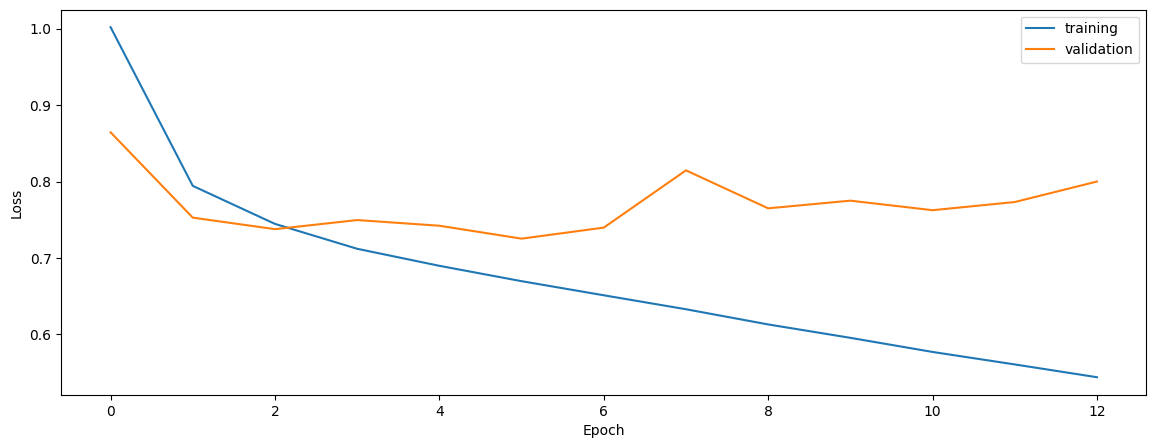

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7604474691579433
0.7418408735534551
0.7523287507727183


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7604474691579433
0.7418408735534551
0.7523287507727183


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7590828967476477
0.7513529966296748
0.7545891401871925


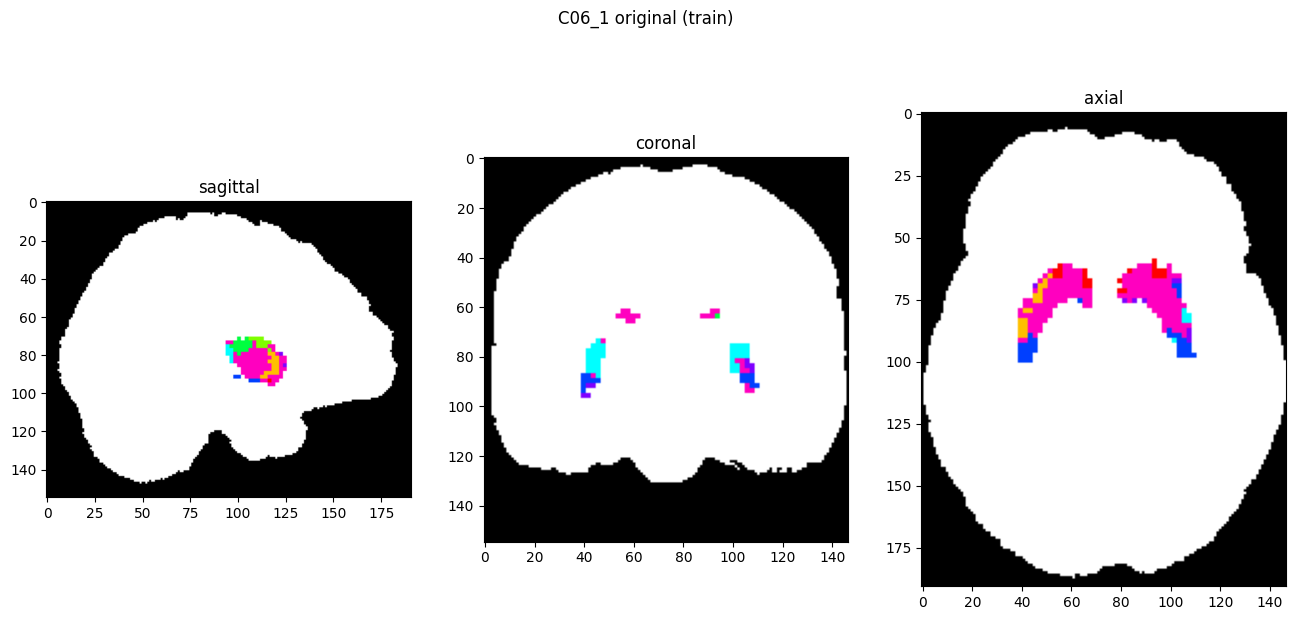

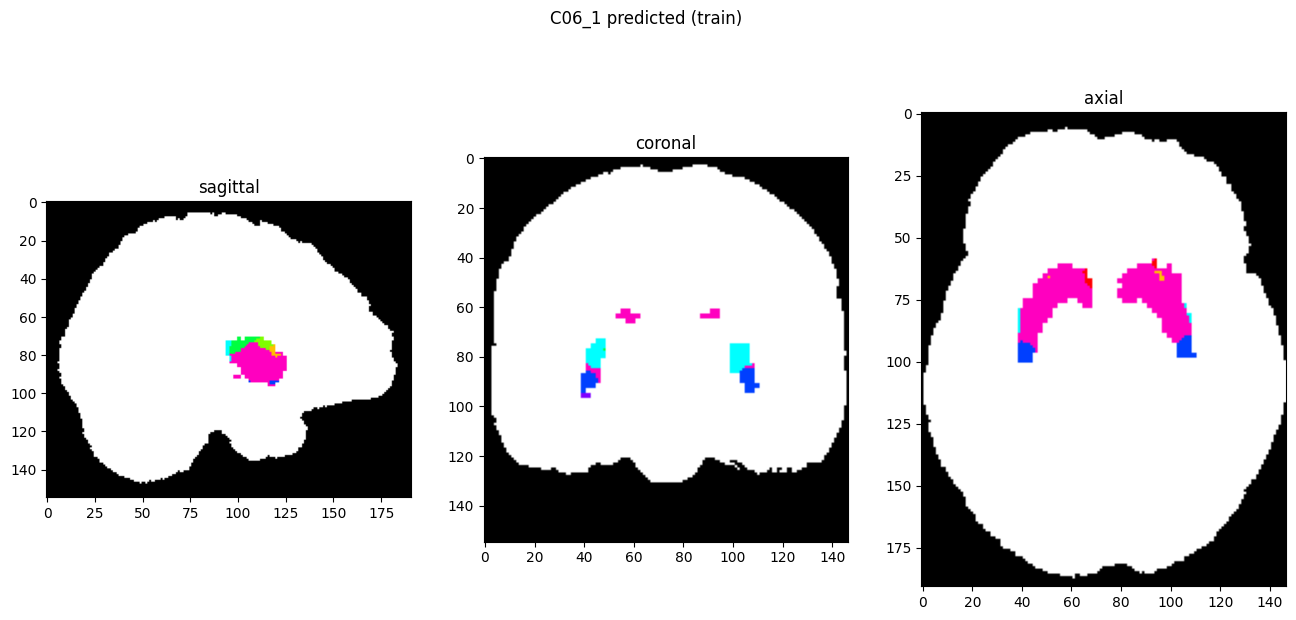

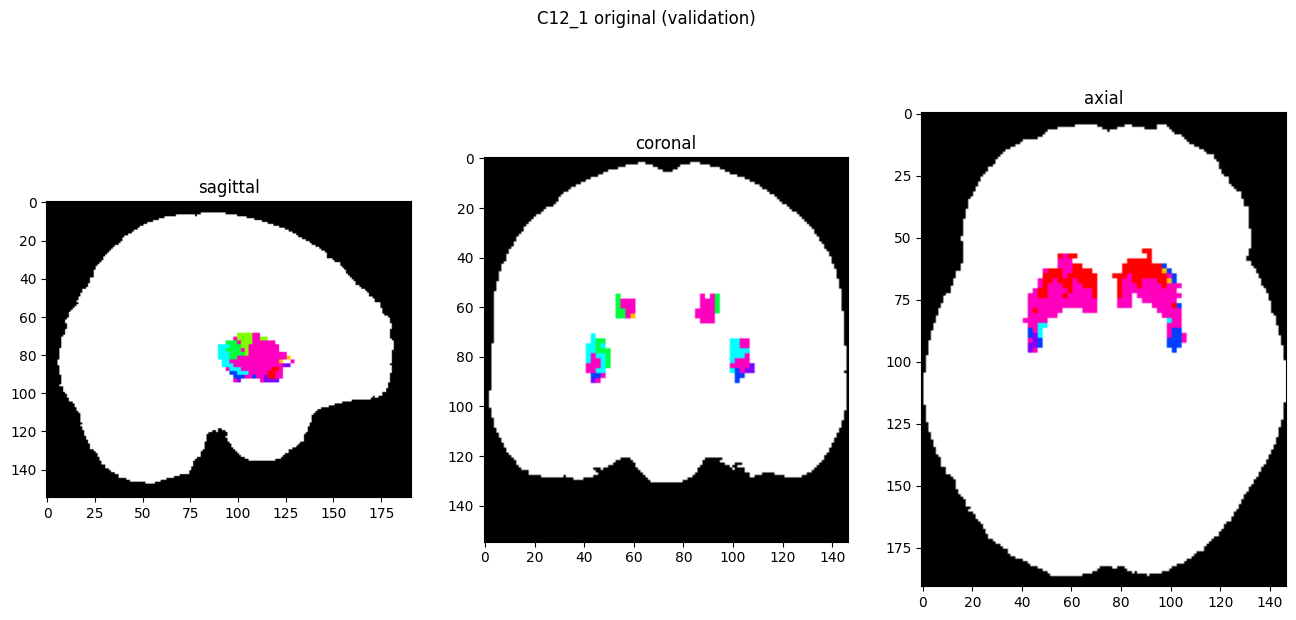

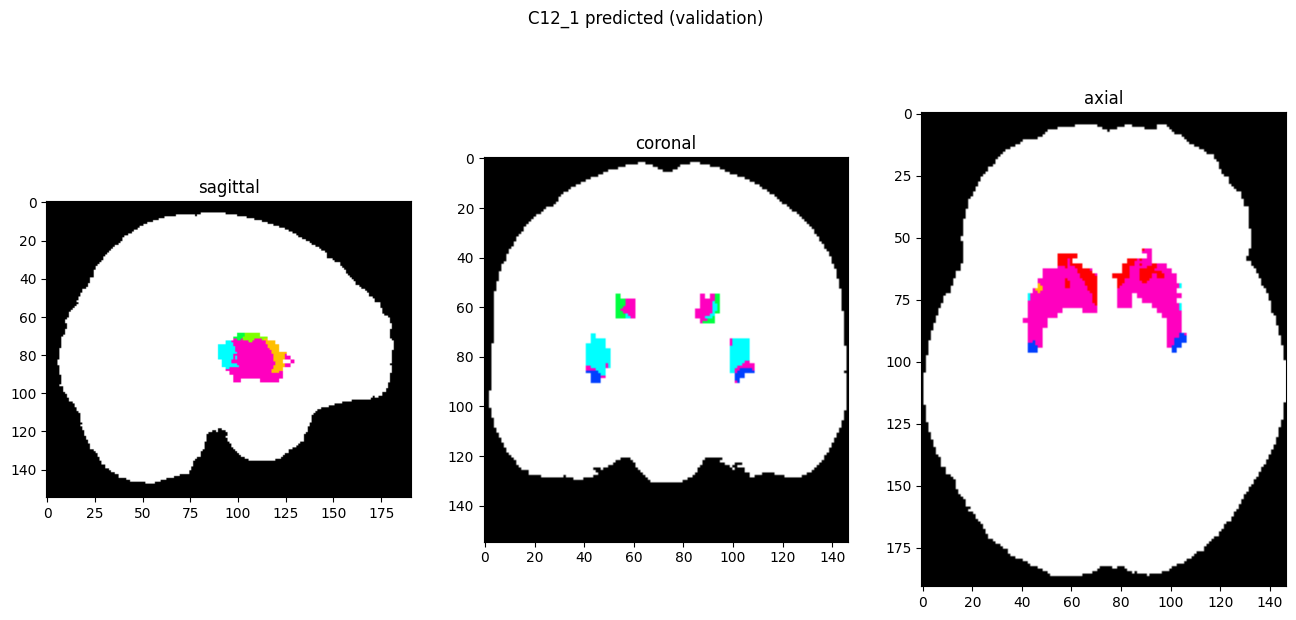

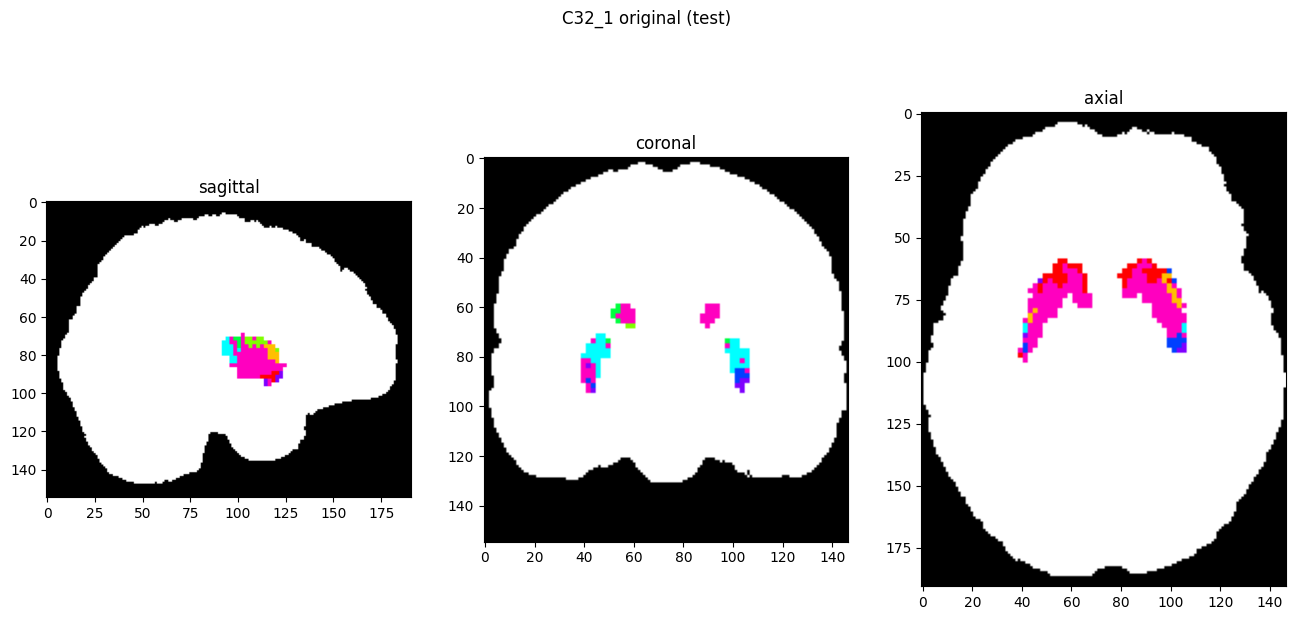

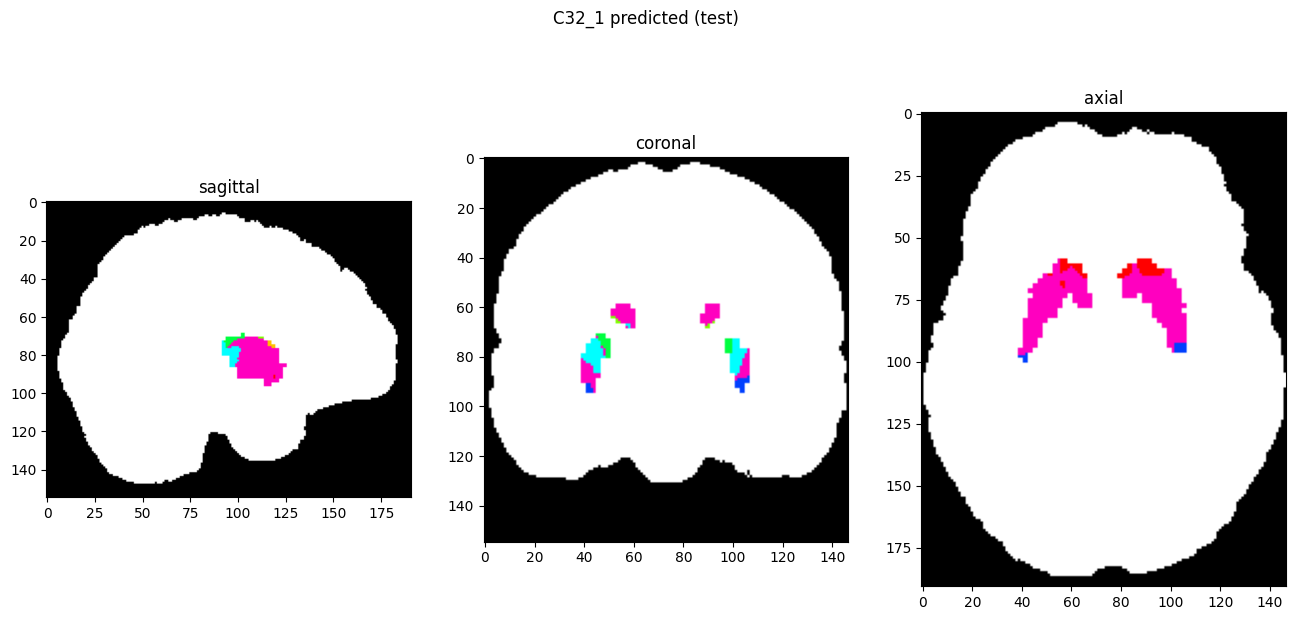

In [10]:
showResults(model, gen, threshold=0)